In [5]:
## Part 1: Implementation of the Paillier Cryptosystem

# imports
from paillier import Paillier
from utils import string_to_int, int_to_string
import gmpy2

# Create an instance with 512-bit keys (sufficient for our tests)
p = Paillier(512)

# Basic encryption / decryption test
message = "Trying to encrypt this message"
ciphertext = p.encrypt(string_to_int(message))
decrypted = int_to_string(p.decrypt(ciphertext))

print("Original:", message)
print("Decrypted:", decrypted)
assert decrypted == message

m1 = 123
m2 = 456
c1 = p.encrypt(m1)
c2 = p.encrypt(m2)

# First property
add_cipher = (c1 * c2) % p.n2
result = p.decrypt(add_cipher)
print("Ciphertext + ciphertext:", result, "==", m1 + m2)
assert result == (m1 + m2) % p.n

add_plain = (c1 * gmpy2.powmod(p.g, m2, p.n2)) % p.n2
result = p.decrypt(add_plain)
print("Ciphertext + plaintext:", result, "==", m1 + m2)
assert result == (m1 + m2) % p.n

mul_plain = gmpy2.powmod(c1, m2, p.n2)
result = p.decrypt(mul_plain)
print("Ciphertext * plaintext:", result, "==", m1 * m2)
assert result == (m1 * m2) % p.n


Original: Trying to encrypt this message using Paillier
Decrypted: Trying to encrypt this message using Paillier
Homomorphic addition: 579 == 579
Addition with plaintext: 579 == 579
Scalar multiplication: 56088 == 56088


Question 1:  
Given ciphertexts $c_1 = E(m_1)$ and $c_2 = E(m_2)$, what can you say about $c_1 \cdot c_2 \mod n^2$?

This operation results in:

$$
E(m_1) \cdot E(m_2) \mod n^2 = E(m_1 + m_2 \mod n)
$$

Question 2:  
Given a ciphertext $c_1 = E(m_1)$ and a plaintext message $m_2$, what can you say about $c_1 \cdot g^{m_2} \mod n^2$?

This operation results in:

$$
c_1 \cdot g^{m_2} \mod n^2 = E(m_1 + m_2 \mod n)
$$

Question 3:  
Given a ciphertext $c_1 = E(m_1)$ and a plaintext message $m_2$, what can you say about $c_1^{m_2} \mod n^2$?

This operation results in:

$$
c_1^{m_2} \mod n^2 = E(m_1 \cdot m_2 \mod n)
$$

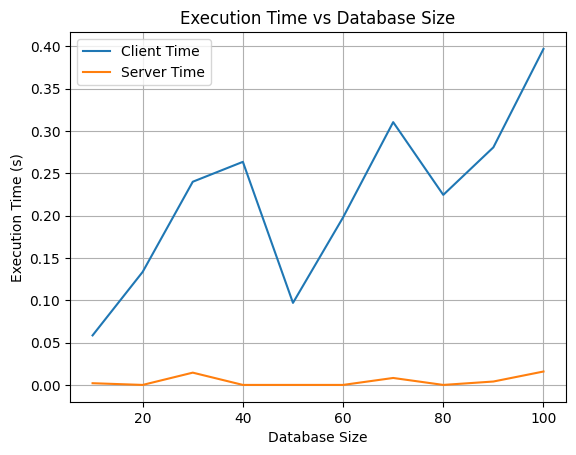

In [6]:
# PIR Protocol

from client import Client
from server import Server
import time
import matplotlib.pyplot as plt

# Initialize values
db_sizes = list(range(10, 110, 10))
bits = 512
index = 0

client_times = []
server_times = []

# Test for each database size
for size in db_sizes:
    client = Client(bits)
    server = Server(size)

    # Measure the time taken to send the request
    t0 = time.time()
    v, pk = client.request(size, index)
    t1 = time.time()
    client_prepare_time = t1 - t0

    # Measure the time taken to answer the request
    t2 = time.time()
    response = server.answerRequest(v, pk)
    t3 = time.time()
    server_answer_time = t3 - t2

    # Measure the time taken to decrypt the response
    t4 = time.time()
    _ = client.decryptAnswer(response)
    t5 = time.time()
    client_decrypt_time = t5 - t4

    client_total_time = client_prepare_time + client_decrypt_time

    client_times.append(client_total_time)
    server_times.append(server_answer_time)

# Plot the results
plt.figure()
plt.plot(db_sizes, client_times, label="Client Time")
plt.plot(db_sizes, server_times, label="Server Time")
plt.xlabel("Database Size")
plt.ylabel("Execution Time (s)")
plt.title("Execution Time vs Database Size")
plt.legend()
plt.grid(True)
plt.show()


Question 1: <br>
To compute $t$ homomorphically, the server uses the encrypted vector:

$$
v = [c_0, c_1, \dots, c_{n-1}]
$$

where:
- $c_i = E(1)$ at the index the client wants to retrieve
- All other $c_j = E(0)$

The server holds the database:

$$
T = [T[0], T[1], \dots, T[n-1]]
$$

Then the server computes:

$$
t = \prod_{j=0}^{n-1} c_j^{T[j]} \mod n^2
$$

Using Paillier's homomorphic properties, this gives us:

$$
t = E(T[i])
$$


# Plot the results
plt.figure()
plt.plot(db_sizes, client_comm, label="Client → Server")
plt.plot(db_sizes, server_comm, label="Server → Client")
plt.xlabel("Database Size")
plt.ylabel("Communication Size (bits)")
plt.title("Communication Size vs Database Size")
plt.legend()
plt.grid(True)
plt.show()

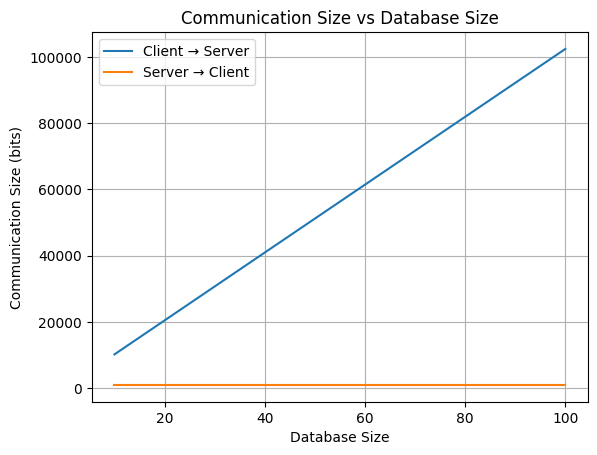

In [1]:
import matplotlib.pyplot as plt

bits = 512 # Size of the Paillier keys
n_bits = 2 * bits  # Size of n (ciphertexts are 2n bits long)
db_sizes = list(range(10, 110, 10))

client_comm = [db_size * n_bits for db_size in db_sizes]
server_comm = [n_bits for _ in db_sizes]

# Plot the results
plt.figure()
plt.plot(db_sizes, client_comm, label="Client → Server")
plt.plot(db_sizes, server_comm, label="Server → Client")
plt.xlabel("Database Size")
plt.ylabel("Communication Size (bits)")
plt.title("Communication Size vs Database Size")
plt.legend()
plt.grid(True)
plt.show()